In [95]:
using HDF5, EzXML, Glob, Dates, Plots, Optim, LineSearches, LsqFit, JuMP, DSP, DataFrames, CSV, StatsBase, LinearRegression, LinearAlgebra, CurveFit
using HDBSCAN, Clustering
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

datapath = "/Users/jjc/Documents/SSC/recs_june_2022"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);

for f = 1:length(files)
    filename = files[f]

    global Data = readCSF(filename)
    # sf = Data["samplingfr"]
    sf = 0.1
    println("File $f out of $(length(files))\n")

    global T = Data["T"]
    global rec_dur_s = Data["rec_dur_s"]
    global start_time = Data["start_time"]
    global end_time = Data["end_time"]
    global infusion_start_frame = Data["infusion_start_frame"]
    global infusion_end_frame = Data["infusion_end_frame"]
    global plateau_start = Data["plateau_start"]
    global plateau_end = Data["plateau_end"]
    global ICP = Data["ICP"]
    global E = Data["E"]
    global P_p = Data["P_p"]
    global P_b = Data["P_b"]
    global I_b = Data["I_b"]
    global I_inf = Data["I_inf"]
    global AMP = Data["AMP"]
    global P_0 = Data["P_0"]

    length(ICP) < infusion_end_frame ? Pm = ICP[infusion_start_frame:end] : Pm = ICP[infusion_start_frame:infusion_end_frame]

    # bayes_res = CSV.File("/Users/jjc/Documents/SSC/recs_june_2022/results_raw_jjc.csv")
    bayes_res = CSV.File("/Users/jjc/Documents/SSC/recs_june_2022/GN_DIRECT_L.csv")
    icmp_res = CSV.File("/Users/jjc/Documents/SSC/recs_june_2022/results_raw_icm.csv")
    # icmp_res = CSV.File("/Users/jjc/Documents/SSC/recs_june_2022/GN_DIRECT_L.csv")
    

    global R_icm = icmp_res["Rcsf"]
    global R_bayes = bayes_res["Rcsf"]

    global Ib_icm = icmp_res["Ib"]
    global Ib_bayes = bayes_res["Ib"]

    global P0_icm = icmp_res["P0"]
    global P0_bayes = bayes_res["P0"]

    global E_icm = icmp_res["E"]
    global E_bayes = bayes_res["E"]

    numsamples = length(ICP)
    infusion_end_frame > numsamples ? (global infusion_end_frame = numsamples) : 0
    P_m = zeros(numsamples)
    P_m .+= P_b

    ICPm = zeros(infusion_end_frame - infusion_start_frame)

    function getPm(I_b, E, P_0, ICP)

        err = 0
        P_model = zeros(numsamples)
        for i = infusion_start_frame:infusion_end_frame
            tᵢ = (i - infusion_start_frame) / 6
            It = I_b + I_inf
            ΔP = P_b - P_0
            y = It * ΔP / (I_b + (I_inf * exp(-E * It * tᵢ))) + P_0 + (Data["I_inf"] * Data["Rn"])
            P_model[i] = y
            err += (ICP[i] - P_model[i])^2
        end

        global goodness_of_fit = 100 * (sqrt(err) / length(P_model) / abs(mean(P_model)))

        ICPm = P_model[infusion_start_frame:infusion_end_frame]
        P_m[infusion_start_frame:infusion_end_frame] = ICPm
        P_m[infusion_end_frame+1:end] .= ICPm[end]
        return P_m, goodness_of_fit
    end


    colorscheme = "light"

    if colorscheme == "light"
        fgcolor = :black
        bgcolor = :white
        icpcol = :cadetblue
        bayescol = :red
        icmcol = :darkorchid4
        infcol = :gray95

    else
        fgcolor = :white
        bgcolor = RGB(0.13, 0.14, 0.14)
        icpcol = :cadetblue
        bayescol = :violet
        icmcol = :orange
        infcol = RGB(0.15, 0.17, 0.17)
    end


    framespan = plateau_end

    tix = [0:30:framespan;]
    # h1 = vline([infusion_start_frame], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor= inflinecol, alpha=0.5, linewidth=1, label="Start of infusion")
    # vline!([infusion_end_frame], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor= inflinecol, alpha=0.5, linewidth=1, label="End of infusion")
    # vline!([plateau_start], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor=:mint, alpha=0.5, linewidth=1, label="Start of plateau")
    # hline!([P_p], linecolor=:coral2, label="Pₚ", linewidth=0.5, alpha=0.5)

    h1 = vspan([infusion_start_frame, infusion_end_frame], color=infcol, legend=:outertopright, label="Infusion period", linecolor=:transparent)

    nr = f
    plot!(ICP, linecolor=icpcol, linewidth=3, label="ICP", alpha=0.7)
    Pm, gof_bayes = getPm(Ib_bayes[nr], E_bayes[nr], P0_bayes[nr], ICP)
    plot!(Pm, linecolor=bayescol, linewidth=2, linestyle=:dash, xlims=[1, framespan],
        xlabel="Time [min]", ylabel="ICP [mmHg]", xticks=(tix, round.(tix ./ 6, digits=2)),
        label="NLOpt", grid=false, titlefontsize=8, titlealign=:left, background=bgcolor, foreground_color_subplot=fgcolor)

    Pm, gof_icm = getPm(Ib_icm[nr], E_icm[nr], P0_icm[nr], ICP)
    plot!(Pm, linecolor=icmcol, linewidth=2, linestyle=:dash, xlims=[1, framespan],
        xlabel="Time [min]", ylabel="ICP [mmHg]", xticks=(tix, round.(tix ./ 6, digits=2)),
        label="ICM+", grid=false, titlefontsize=8, titlealign=:left, background=bgcolor, foreground_color_subplot=fgcolor)

    txtcontent = ("NLOpt:" * "\nIₐ = $(round(Ib_bayes[nr], digits=2)) [mL/min]\n" * "E = $(round(E_bayes[nr],digits=2)) [mmHg/mL]\n" * "P₀ = $(round(P0_bayes[nr],digits=2)) [mmHg]\n" * "Rₒ = $(round(R_bayes[nr],digits=2))  [mmHg/mL/min]\n" * "err = $(round(gof_bayes, digits=3))\n" * "\nICM+:" * "\nIₐ = $(round(Ib_icm[nr], digits=2)) [mL/min]\n" * "E = $(round(E_icm[nr],digits=2)) [mmHg/mL]\n" * "P₀ = $(round(P0_icm[nr],digits=2)) [mmHg]\n" * "Rₒ = $(round(R_icm[nr],digits=2))  [mmHg/mL/min]\n" * "err = $(round(gof_icm, digits=3))\n")

    # txtcontent = ("ICM+:" * "\nIₐ = $(round(Ib_icm[nr], digits=2)) [mL/min]\n" * "E = $(round(E_icm[nr],digits=2)) [mmHg/mL]\n" * "P₀ = $(round(P0_icm[nr],digits=2)) [mmHg]\n" * "Rₒ = $(round(R_icm[nr],digits=2))  [mmHg/mL/min]\n" * "err = $(round(gof_icm, digits=3))\n")

    annotate!(framespan * 1.1, 10, text(txtcontent, fgcolor, :left, 7))

    P = ICP[infusion_start_frame:infusion_end_frame]
    dpress = zeros(length(P))
    dvol = zeros(length(P))
    # dpress[1] = 1
    for i = 2:length(P)
        dvol[i] = dvol[i-1] + (I_inf + Ib_bayes[nr] - (P[i] - P0_bayes[nr]) / R_bayes[nr]) * 1 / 6
        dpress[i] = (P[i] - P0_bayes[nr]) / (P_b - P0_bayes[nr])
    end

    # min_cluster_size=5
    # min_samples = 3

    # min_cluster_size = 100
    # min_samples = min_cluster_size

    # try
    # X = hcat(dvol, log.(dpress))'
    # result = hdbscan(X; min_cluster_size, min_samples)
    # global res = result.assignments
    # catch
    #     continue
    # end

    # h2 = plot(dvol[res.==0], (dpress[res.==0]), seriestype=:scatter, markersize=5, markerstrokewidth=0.5, markerstrokecolor=:black, linewidth=1, label="Model", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, size=(700, 800), xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]", legend=false)
    # for i = 1:maximum(res)
    #     plot!(dvol[res.==i], (dpress[res.==i]), seriestype=:scatter, markerstrokewidth=0.5, markersize=5, markerstrokecolor=:black, linewidth=1, label="Model", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]", legend=:outertopright)
    # end

    # indCond = res .== 0
    # indCond = (res .== 1 .|| res .== 2)
    # volRes = dvol[indCond]
    # pressRes = dpress[indCond]

    volRes = dvol[dpress.>0]
    pressRes = dpress[dpress.>0]
    coefval = CurveFit.curve_fit(LinearFit, volRes, log.(pressRes))
    # fitvals = CurveFit.exp_fit(volRes, pressRes)
    fitted_curve = coefval.(volRes)
    y = log.(pressRes)
    ydash = mean(y)
    SSres = sum((y .- fitted_curve).^2)
    SStot = sum((y .- ydash).^2)
    R2 = 1 - (SSres/SStot)
    MSE = SSres/length(y)
    # println(MSE)


    h2 = plot(volRes, log.(pressRes), seriestype=:scatter, makersize=5, markerstrokewidth=0.5, markerstrokecolor=:black, linewidth=1, label="Model", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, size=(700,700), xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]", legend=false)
    
    # h2 = plot(dvol, dpress, seriestype=:scatter, markercolor=:cadetblue, markersize=6, markerstrokewidth=0.5, markerstrokecolor=infcol, linewidth=1, label="Model", grid=true, titlefontsize=8, titlealign=:left, background=RGB(0.13, 0.14, 0.14), size=(700, 800), xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]", legend=false)
    plot!(volRes, fitted_curve, lw=2, linecolor=:orange, linestyle=:dash, legend=false)

    title!("R² = $(round(R2, digits=3))")
    plot(h1, h2, layout=(2, 1))

    # plot(h1)
    savefig("/Users/jjc/Documents/SSC/recs_june_2022/combined/" * filename[length(datapath)+2:end-5] * "combined.pdf")
    # savefig("/Users/jjc/Documents/SSC/recs_june_2022/combined/" * filename[length(datapath)+2:end-5] * "_BayesOptvNLopt.pdf")
    # println(filename[length(datapath)+2:end-5] * " " * "$(round(I_b,digits=3))" * " " * "$(E_bayes[nr])" * " " * "$(P0_bayes[nr])" * "\n\n")
end

File 1 out of 96

0.01771269269806358
File 2 out of 96

0.22651724337051368
File 3 out of 96

0.44027137963118734
File 4 out of 96

0.42265129039659
File 5 out of 96

0.054432269489550586
File 6 out of 96

0.09518559255318584
File 7 out of 96

0.023320869033886246
File 8 out of 96

0.01809724645082858
File 9 out of 96

0.008173012144629207
File 10 out of 96

0.000973893406225992
File 11 out of 96

0.0136733244448497
File 12 out of 96

0.021186096676408313
File 13 out of 96

0.02616863695622287
File 14 out of 96

0.08837804582755472
File 15 out of 96

0.08075635101288402
File 16 out of 96

0.03332085652445364
File 17 out of 96

0.003947167114253903
File 18 out of 96

0.08635873704076111
File 19 out of 96

0.016102780196313594
File 20 out of 96

NaN
File 21 out of 96

0.052742461704570226
File 22 out of 96

0.019499222309395832
File 23 out of 96

0.011143433998139564
File 24 out of 96

0.0049939748805909005
File 25 out of 96

0.007120877087323534
File 26 out of 96

0.0027970218111241256


15.288, 7.52
12.844, 8.0
P-value: 6.0e-6


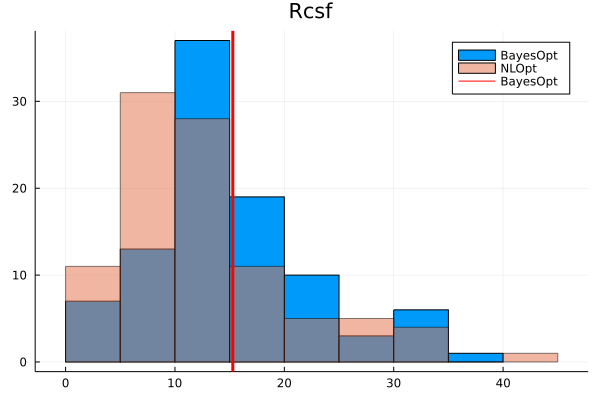

In [45]:
using HypothesisTests, CSV, Plots, StatsBase
dfBayes = CSV.File("/Users/jjc/Documents/SSC/recs_june_2022/Bayes_ISO5.csv")
dfNLOpt = CSV.File("/Users/jjc/Documents/SSC/recs_june_2022/GN_DIRECT_L.csv")


# println(round(mean(dfBayes["error"]),digits=2))
# println(round(std(dfBayes["error"]),digits=2))
# println(round(mean(dfNLOpt["error"]),digits=2))
# println(round(std(dfNLOpt["error"]),digits=2))

# println("P-value: " , round(pvalue(OneSampleTTest(vec(dfBayes["error"]), vec(dfNLOpt["error"]))),digits=6))

param = "Rcsf"
println(round(mean(dfBayes[param]),digits=3), ", ", round(std(dfBayes[param]),digits=3))
println(round(mean(dfNLOpt[param]),digits=3), ", ", round(std(dfNLOpt[param]),digits=3))


println("P-value: " , round(pvalue(OneSampleTTest(vec(dfBayes[param]), vec(dfNLOpt[param]))),digits=6))


histogram(dfBayes[param], label="BayesOpt")
histogram!(dfNLOpt[param], alpha=0.5, label="NLOpt")
vline!([mean(dfBayes[param])], color=:red, width=3, label="BayesOpt")
title!(param)



UndefVarError: UndefVarError: dvol not defined

In [8]:
dfBayes["E"]

96-element Vector{Float64}:
 0.033
 0.091
 0.166
 0.104
 0.291
 0.088
 0.068
 0.102
 0.032
 0.096
 ⋮
 0.165
 0.154
 0.161
 0.31
 0.137
 0.149
 0.652
 0.142
 0.102

In [83]:
-log(1.0 - 0.2)

0.2231435513142097

In [ ]:
using HDBSCAN, Clustering

X = hcat(dvol, log.(dpress))'

# min_cluster_size=5
# min_samples = 3

min_cluster_size=20
min_samples = min_cluster_size
result = hdbscan(X; min_cluster_size, min_samples)

probabilities(result)
exemplars(result)       # Computed at first call, this takes long time
outlier_scores(result)
raw_data(result) == X

res = result.assignments

plot(dvol[res .== 0], (dpress[res .== 0]), seriestype=:scatter, markerstrokewidth=.5, markerstrokecolor=:black, linewidth=1, label="Model", grid=true, titlefontsize=8, titlealign=:left, background=RGB(0.13, 0.14, 0.14), xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]", legend=:outertopright)
for i = 1:maximum(res)
    plot!(dvol[res .== i], (dpress[res .== i]), seriestype=:scatter, markerstrokewidth=.5, markerstrokecolor=:black, linewidth=1, label="Model", grid=true, titlefontsize=8, titlealign=:left, background=RGB(0.13, 0.14, 0.14), xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]", legend=:outertopright)
end

indCond = res.==0
# indCond = (res .== 1 .|| res .== 2)
volRes = dvol[indCond]
pressRes = dpress[indCond]
coefval = CurveFit.curve_fit(ExpFit, volRes, pressRes)
fitvals = CurveFit.exp_fit(volRes, pressRes)
fitted_curve = coefval.(volRes)

println(round(fitvals[2], digits=3))
plot!(volRes,fitted_curve, lw=3, linecolor=:orange, linestyle=:dash, yaxis=:log, legend=:outertopright)